In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'R_RLC.csv'
fr = pd.read_csv(FILE)

In [2]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VLC = np.array(fr['V_LC']) # V
ν = np.array(fr['Freq (Hz)']) # Hz 
ω = 2*np.pi*ν # rad/s
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseLC (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = np.array(fr['sigmaV_in']) # media 4 = sqrt(16)
sigma_VR = np.array(fr['sigmaV_R'])  # media 4 = sqrt(16)
sigma_VL = np.array(fr['sigmaV_LC']) 

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) /4 # rad
sigma_ΦLC = np.array(fr['sigmaF_LC'], dtype=np.float64) * (np.pi/180.0) /4 # rad

###### Calcolo funzioni di trasferimento ######

modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((sigma_VR/Vin)**2))
# print(modHR,sigma_modHR)

##### SISTEMAZIONE PHIR #######

# quando PHI_R è negativo, aggiungo 2pi

shift = lambda x: x + np.pi if x < 0 else x
shift = np.vectorize(shift)
ΦR = shift(ΦR)

- $|H_R(\omega)| = \frac{\omega CR}{\sqrt{(1-\omega^2LC)^2 + \omega^2C^2 (R+R_L)^2}}$

- $\angle H_R(\omega) = \frac{\pi}{2}-arctan(\frac{\omega C(R+R_L)}{1-\omega^2LC})$

In [3]:
def mod_HR_f(omega, C,L):
    numerator = omega * C * R
    denominator = np.sqrt((1 - (omega**2) * L * C)**2 + (omega**2) * (C**2) * (R + RL)**2)
    result = numerator / denominator
    return result

def arg_HR_f(omega, C,L):
    numerator = omega * C * (R + RL)
    denominator = 1 - (omega**2) * L * C
    angle = np.pi/2-np.arctan(numerator / denominator)
    return angle

In [9]:
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[10*10**-9,0.04])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[10*10**-9,0.04])
print(fit_mod_HR)
print(fit_arg_HR)

   
Parameters: [9.70000301e-09 4.87228980e-02] 
Sigma parameters: [2.93643192e-10 1.49616380e-03]

sigmaY: [0.00818846 0.00484026 0.00547997 0.0095385  0.00853693 0.0156795
 0.03463868 0.03656353 0.03970696 0.04210183 0.04381891 0.04525339
 0.04561979 0.04561979 0.04525339 0.04381891 0.04210183 0.03955583
 0.03631616 0.03434328 0.03294805 0.03170822 0.03135497]

chiquadro ridotto: 0.51
df: 21
pvalue: 100.0%
covariance matrix: [[ 7.18824364e-20 -2.83362807e-14]
 [-2.83362807e-14  1.86612703e-06]]    

   
Parameters: [9.46783568e-09 5.34441823e-02] 
Sigma parameters: [5.20419872e-10 2.95555093e-03]

sigmaY: [0.01047198 0.00654498 0.00654498 0.01090831 0.00436332 0.00654498
 0.00436332 0.00872665 0.00654498 0.00654498 0.00872665 0.01090831
 0.00872665 0.01308997 0.00872665 0.00872665 0.00654498 0.01090831
 0.00872665 0.01308997 0.01308997 0.01308997 0.02181662]

chiquadro ridotto: 19.21
df: 21
pvalue: 57.2%
covariance matrix: [[ 2.25782699e-19 -3.06022689e-13]
 [-3.06022689e-13  7.28215

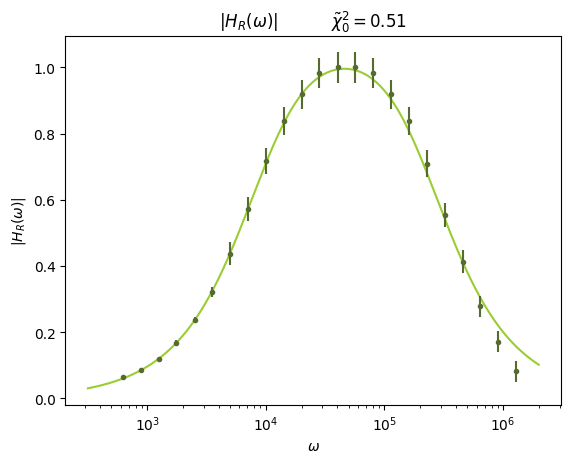

In [10]:
x = np.logspace(2.5, 6.3, 1000)
y = mod_HR_f(x, *fit_mod_HR.bval)

plt.plot(x, y, label='Fit',color='yellowgreen')
plt.errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='.',color='darkolivegreen')
plt.xlabel('$\omega$')
plt.ylabel('$|H_R(\omega)|$')
plt.xscale('log')
plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2 = $' + str(fit_mod_HR.rchisquare))
plt.show()

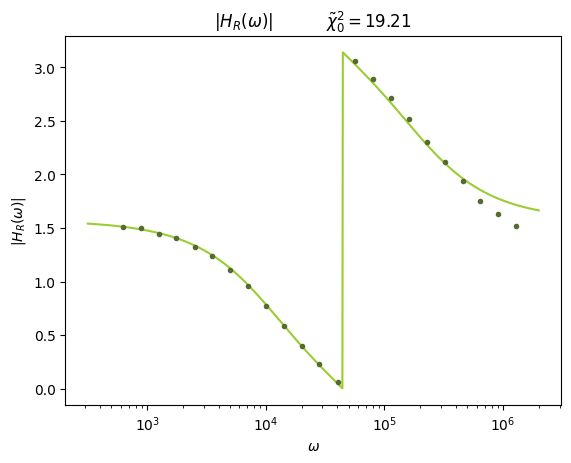

In [11]:
x = np.logspace(2.5, 6.3, 1000)
y = arg_HR_f(x,10*10**-9,0.04)
y = arg_HR_f(x, *fit_arg_HR.bval)

plt.plot(x, y, label='Fit',color='yellowgreen')
plt.errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.',color='darkolivegreen')
plt.xlabel('$\omega$')
plt.ylabel('$|H_R(\omega)|$')
plt.xscale('log')
plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2 = $' + str(fit_arg_HR.rchisquare))
plt.show()